Lab 6, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Analysis of accuracy decrease of tracking in conditions of biased state noise

The objective of this laboratory work is to analyze the sensitivity of estimation results obtained by
a Kalman filter that doesn’t take into account bias of state and measurement noise. This will bring
about a deeper understanding of main difficulties of practical Kalman filter implementation and
skills to overcome these difficulties to get optimal assimilation output.

This laboratory work consists of one part:
1. Divergence of Kalman filter when bias of state noise (acceleration) is neglected in assimilation algorithm. Development of optimal Kalman filter that takes into account bias of state noise (acceleration). 

Let's generate a true trajectory $X_i$ of an object motion disturbed by normally distributed biased random acceleration

$$
x_i = x_{i-1} + V_{i-1}T + \cfrac{a_{i-1}T^2}{2}
$$

$$
V_i = V_{i−1} + a_{i-1}T
$$

Size of trajectory is 200 points. Initial conditions:

$$
x_1 = 5
$$

$$
V_1 = 1
$$

$$
T = 1
$$

1. Variance of acceleration noise $a_i$, $\sigma_a^2 = 0.2^2$
2. Bias (mathematical expectation) of acceleration noise $a_i$, $q = 0.2$

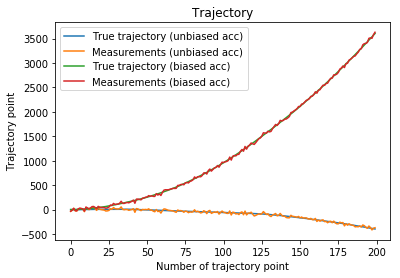

In [2]:
#noise of acceleration
sigmaacc = 0.2
q = 0.2
acc = np.random.normal(loc=0, scale=sigmaacc, size=200)
acc_b = acc + q

#steps, speed and time interval
x = np.zeros(len(acc))
x_b = np.zeros(len(acc))
x[0] = 5
x_b[0] = 5

V = np.zeros(len(acc))
V_b = np.zeros(len(acc))
V[0] = 1
V_b[0] = 1

T = 1

#trajectory
for i in range(len(acc)):
    x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
    V[i] = V[i-1] + acc[i-1]*T
    x_b[i] = x_b[i-1] + V_b[i-1]*T + acc_b[i-1]*(T**2)/2
    V_b[i] = V_b[i-1] + acc_b[i-1]*T
    
#noise of measurements
sigmaeta = 20
eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)

#measurements of the steps
z = np.zeros(len(acc))
z_b = np.zeros(len(acc))
for i in range(len(acc)):
    z[i] = x[i] + eta[i]
    z_b[i] = x_b[i] + eta[i]
    

plt.plot(x, '-')
plt.plot(z, '-')
plt.plot(x_b, '-')
plt.plot(z_b, '-')
plt.title('Trajectory')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory (unbiased acc)', 'Measurements (unbiased acc)', 'True trajectory (biased acc)', 'Measurements (biased acc)'], loc = 'best')
plt.show()

Obtain estimates of state vector $X$ by Kalman filter in assumption of unbiased acceleration. In this conditions it will be non-optimal filter.

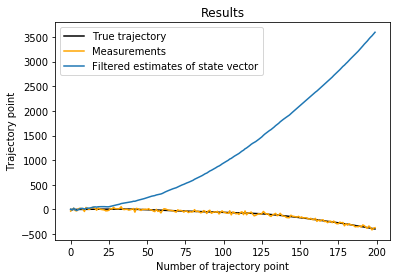

In [3]:
#making state vectors
X = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X[i,0] = x_b[i]
    X[i,1] = V_b[i]
    X[i] = np.matrix([[x_b[i]], [V_b[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])

#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
P[0] = np.matrix([[10**4, 0], [0, 10**4]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])
e = np.zeros(len(acc))
K = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    K[i] = np.matrix([[0], [0]])

#Let's start Kalman filter algorithm
for i in range(1, len(acc)):
    #Prediction(extrapolation)
    X[i] = PHI @ X[i-1]
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
    e[i] = (H @ P[i] @ H.T + R)**(-1)
    K[i] = e[i] * (P[i] @ H.T)
    X[i] = X[i] + K[i]*np.array([z_b[i] - H @ X[i]])
    P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    

plt.plot(x, '-', color='black')
plt.plot(z, '-', color='orange')
plt.plot(X[:,0,0], '-')
plt.title('Results')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates of state vector'], loc = 'best')
plt.show()

We can see that the filter diverges

Let's make 500 runs of filter and estimate dynamics of mean-squared error of estimation of coordinate $x_i$ over observation interval.

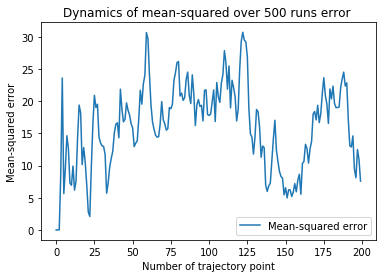

In [6]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x_b[i]
        X[i,1] = V_b[i]
        X[i] = np.matrix([[x_b[i]], [V_b[i]]])

    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])

    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])
    e = np.zeros(len(acc))
    K = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        K[i] = np.matrix([[0], [0]])

    #Let's start Kalman filter algorithm
    for i in range(1, len(acc)):
        #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
        #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z_b[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]   
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x_b[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error ')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error'], loc = 'best')
plt.show()

Now let's compare true estimation error obtained in the last cell with errors of estimation $P_i$ provided by Kalman filter algorithm

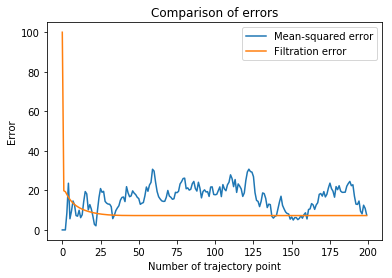

In [7]:
plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.plot(np.sqrt(P[:, 0, 0]), '-')
plt.title('Comparison of errors')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error','Filtration error'], loc = 'best')
plt.show()

As bias of acceleration is neglected in Kalman filter algorithm, than true estimation errors are greater than calculation errors of estimation $P_i$ as filter is nonoptimal

Let's develop optimal Kalman filter algorithm that takes into account bias of acceleration (state noise). We will adjust equation to get the predicted (extrapolated) estimate by introducing correction $Gq$.

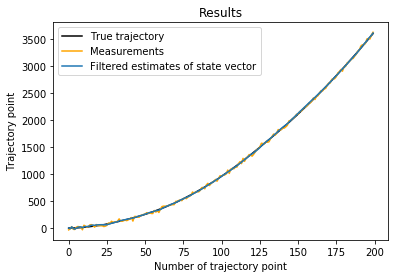

In [8]:
#making state vectors
X_b = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X_b[i,0] = x_b[i]
    X_b[i,1] = V_b[i]
    X_b[i] = np.matrix([[x_b[i]], [V_b[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])

#initial filtered estimate
X_b[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
P[0] = np.matrix([[10**4, 0], [0, 10**4]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])
e = np.zeros(len(acc))
K = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    K[i] = np.matrix([[0], [0]])

#Let's start Kalman filter algorithm
for i in range(1, len(acc)):
    #Prediction(extrapolation)
    X_b[i] = PHI @ X_b[i-1] + q*G
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
    e[i] = (H @ P[i] @ H.T + R)**(-1)
    K[i] = e[i] * (P[i] @ H.T)
    X_b[i] = X_b[i] + K[i]*np.array([z_b[i] - H @ X_b[i]])
    P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    

plt.plot(x_b, '-', color='black')
plt.plot(z_b, '-', color='orange')
plt.plot(X_b[:,0,0], '-')
plt.title('Results')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates of state vector'], loc = 'best')
plt.show()

In [11]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #making state vectors
    X_b = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X_b[i,0] = x_b[i]
        X_b[i,1] = V_b[i]
        X_b[i] = np.matrix([[x_b[i]], [V_b[i]]])

    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])

    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])
    e = np.zeros(len(acc))
    K = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        K[i] = np.matrix([[0], [0]])

    #Let's start Kalman filter algorithm
    for i in range(1, len(acc)):
        #Prediction(extrapolation)
        X_b[i] = PHI @ X_b[i-1] + q*G
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
        #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X_b[i] = X_b[i] + K[i]*np.array([z_b[i] - H @ X_b[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]   
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X_b[i,0,0] - x_b[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

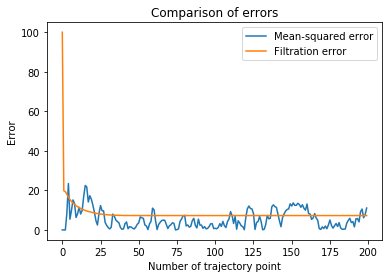

In [12]:
plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.plot(np.sqrt(P[:, 0, 0]), '-')
plt.title('Comparison of errors')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error','Filtration error'], loc = 'best')
plt.show()

In optimal conditions these errors are kinda similar

We analyzed the sensitivity of estimation results obtained by a Kalman filter that doesn’t take into account bias of state and measurement noise. This brought a deeper understanding of main difficulties of practical Kalman filter implementation and skills to overcome these difficulties to get optimal assimilation output.